### Importing Dependencies

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import math
from models import *
from CNN_data_loader import *

c:\Users\IDEAL COMPUTER'S\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Defining Different Models

In [2]:
def conv3x3(in_planes, out_planes, strd=1, padding=1, bias=False):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3,
                     stride=strd, padding=padding, bias=bias)


class ConvBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(ConvBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, int(out_planes / 2))
        self.bn2 = nn.BatchNorm2d(int(out_planes / 2))
        self.conv2 = conv3x3(int(out_planes / 2), int(out_planes / 4))
        self.bn3 = nn.BatchNorm2d(int(out_planes / 4))
        self.conv3 = conv3x3(int(out_planes / 4), int(out_planes / 4))

        if in_planes != out_planes:
            self.downsample = nn.Sequential(
                nn.BatchNorm2d(in_planes),
                nn.ReLU(True),
                nn.Conv2d(in_planes, out_planes,
                          kernel_size=1, stride=1, bias=False),
            )
        else:
            self.downsample = None

    def forward(self, x):
        residual = x

        out1 = self.bn1(x)
        out1 = F.relu(out1, True)
        out1 = self.conv1(out1)

        out2 = self.bn2(out1)
        out2 = F.relu(out2, True)
        out2 = self.conv2(out2)

        out3 = self.bn3(out2)
        out3 = F.relu(out3, True)
        out3 = self.conv3(out3)

        out3 = torch.cat((out1, out2, out3), 1)

        if self.downsample is not None:
            residual = self.downsample(residual)

        out3 += residual

        return out3


class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class HourGlass(nn.Module):
    def __init__(self, num_modules, depth, num_features):
        super(HourGlass, self).__init__()
        self.num_modules = num_modules
        self.depth = depth
        self.features = num_features

        self._generate_network(self.depth)

    def _generate_network(self, level):
        self.add_module('b1_' + str(level), ConvBlock(self.features, self.features))

        self.add_module('b2_' + str(level), ConvBlock(self.features, self.features))

        if level > 1:
            self._generate_network(level - 1)
        else:
            self.add_module('b2_plus_' + str(level), ConvBlock(self.features, self.features))

        self.add_module('b3_' + str(level), ConvBlock(self.features, self.features))

    def _forward(self, level, inp):
        # Upper branch
        up1 = inp
        up1 = self._modules['b1_' + str(level)](up1)

        # Lower branch
        low1 = F.avg_pool2d(inp, 2, stride=2)
        low1 = self._modules['b2_' + str(level)](low1)

        if level > 1:
            low2 = self._forward(level - 1, low1)
        else:
            low2 = low1
            low2 = self._modules['b2_plus_' + str(level)](low2)

        low3 = low2
        low3 = self._modules['b3_' + str(level)](low3)

        up2 = F.interpolate(low3, scale_factor=2, mode='nearest')

        return up1 + up2

    def forward(self, x):
        return self._forward(self.depth, x)


class FAN(nn.Module):

    def __init__(self, num_modules=1):
        super(FAN, self).__init__()
        self.num_modules = num_modules

        # Base part
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 128)
        self.conv4 = ConvBlock(128, 256)

        # Stacking part
        for hg_module in range(self.num_modules):
            self.add_module('m' + str(hg_module), HourGlass(1, 4, 256))
            self.add_module('top_m_' + str(hg_module), ConvBlock(256, 256))
            self.add_module('conv_last' + str(hg_module),
                            nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0))
            self.add_module('bn_end' + str(hg_module), nn.BatchNorm2d(256))
            self.add_module('l' + str(hg_module), nn.Conv2d(256,
                                                            68, kernel_size=1, stride=1, padding=0))

            if hg_module < self.num_modules - 1:
                self.add_module(
                    'bl' + str(hg_module), nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0))
                self.add_module('al' + str(hg_module), nn.Conv2d(68,
                                                                 256, kernel_size=1, stride=1, padding=0))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), True)
        x = F.avg_pool2d(self.conv2(x), 2, stride=2)
        x = self.conv3(x)
        x = self.conv4(x)

        previous = x

        outputs = []
        for i in range(self.num_modules):
            hg = self._modules['m' + str(i)](previous)

            ll = hg
            ll = self._modules['top_m_' + str(i)](ll)

            ll = F.relu(self._modules['bn_end' + str(i)]
                        (self._modules['conv_last' + str(i)](ll)), True)

            # Predict heatmaps
            tmp_out = self._modules['l' + str(i)](ll)
            outputs.append(tmp_out)

            if i < self.num_modules - 1:
                ll = self._modules['bl' + str(i)](ll)
                tmp_out_ = self._modules['al' + str(i)](tmp_out)
                previous = previous + ll + tmp_out_

        return outputs


class ResNetDepth(nn.Module):

    def __init__(self, block=Bottleneck, layers=[3, 8, 36, 3], num_classes=68):
        self.inplanes = 64
        super(ResNetDepth, self).__init__()
        self.conv1 = nn.Conv2d(3 + 68, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

##### Device Configuration

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### DataLoading

In [4]:
data_path = r"D:\OneDrive - Habib University\acedemics\semester5\DL\project\project_files\dataset\Theory of Automata in Urdu\lec_01_segmented1"
X = load_segment(data_path, 10,30)


loaded : seg_10
loaded : seg_11
loaded : seg_12
loaded : seg_13
loaded : seg_14
loaded : seg_15
loaded : seg_16
loaded : seg_17
loaded : seg_18
loaded : seg_19
loaded : seg_20
loaded : seg_21
loaded : seg_22
loaded : seg_23
loaded : seg_24
loaded : seg_25
loaded : seg_26
loaded : seg_27
loaded : seg_28
loaded : seg_29


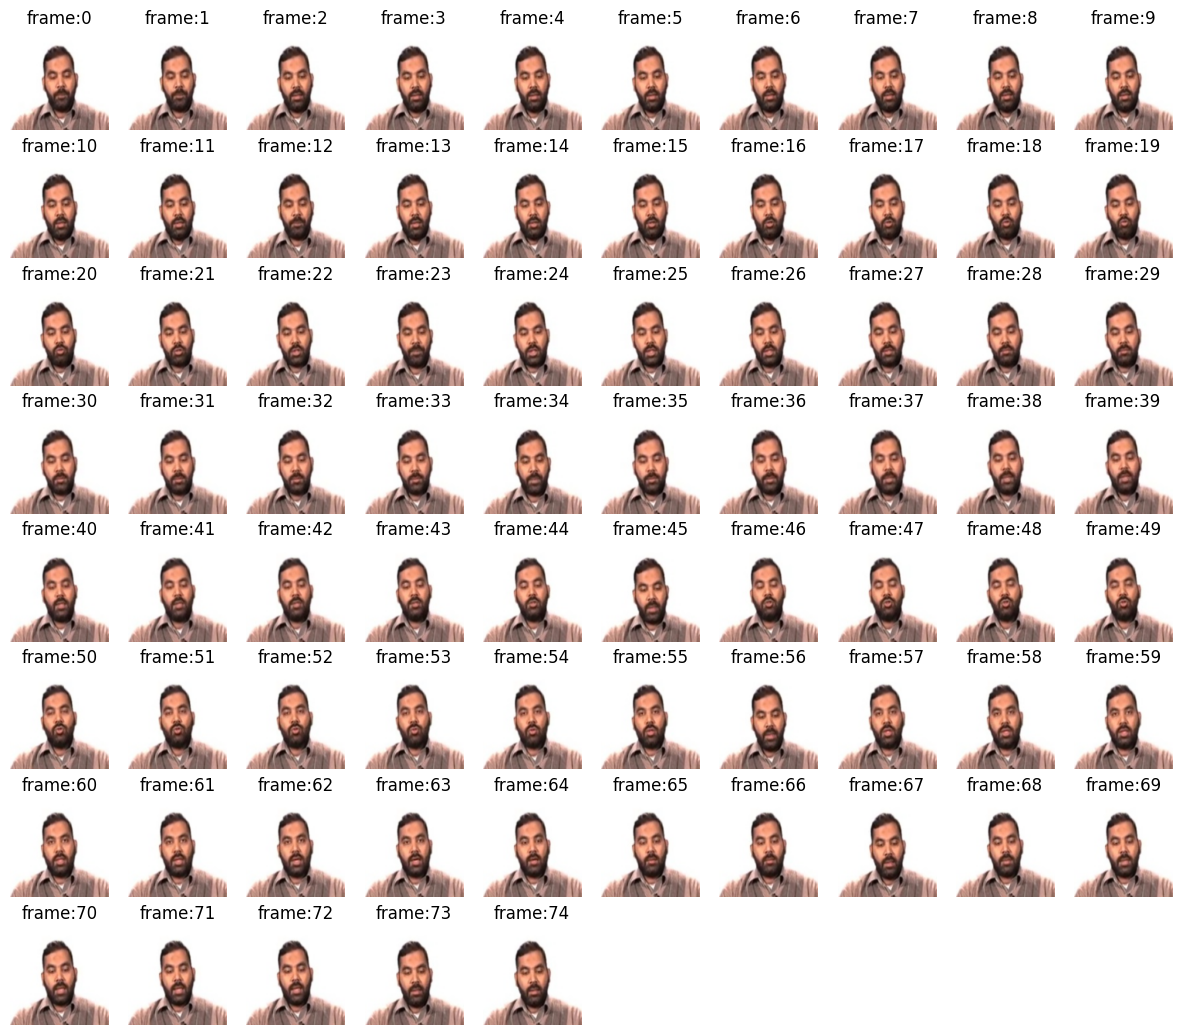

In [5]:
plot_segment(X[15])

### DataShuffling

This section will shuffle our input/training data so that we have a randomized shuffle of our data and do not risk feeding data with a pattern. Anorther objective here is to send the data in batches. This is a good step to practice in order to make sure the neural network does not overfit our data. NN’s are too prone to overfitting just because of the exorbitant amount of data that is required. For each batch size, the neural network will run a back propagation for new updated weights to try and decrease loss each time.

In [ ]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

##### Hyper-Parameters

In [ ]:
num_epochs = 5
batch_size = 4
learning_rate = 0.001

##### Model Instantiated

In [ ]:
model = ResNetDepth().to(device)

##### Optimizer and Loss setting

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Training Loop

In [ ]:
n_total_steps = len(trainset)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainset):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
print('Finished Training')

### Testing Loop

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

### Save Model to \<path\>

In [ ]:
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)